In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, pipeline

import pandas as pd




import matplotlib.pyplot as plt

import seaborn as sns


In [4]:
# df_combined = pd.read_csv("../aggregated_data/combined_review_data.csv")
df_combined = pd.read_csv("combined_review_data.csv")

In [5]:
df_combined.head()

,review,review_datetime,data_source,app_name,upvote_count,total_comments,app_rating
0,uber eats for owls? will they ever come out wi...,2025-04-20 21:51:15,Reddit,UberEats,1.0,2.0,NaN
1,serious question yall is it worth going out to...,2025-04-20 21:41:21,Reddit,UberEats,1.0,1.0,NaN
2,ubereats charged me for a successful chargebac...,2025-04-20 20:50:04,Reddit,UberEats,1.0,2.0,NaN
3,ubereats driver scammed me by buying half the ...,2025-04-20 20:48:13,Reddit,UberEats,1.0,9.0,NaN
4,ubereats why you do this? family went out of t...,2025-04-20 20:19:15,Reddit,UberEats,1.0,3.0,NaN


In [6]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13582 entries, 0 to 13581
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review           13582 non-null  object 
 1   review_datetime  13581 non-null  object 
 2   data_source      13581 non-null  object 
 3   app_name         13581 non-null  object 
 4   upvote_count     13581 non-null  float64
 5   total_comments   7243 non-null   float64
 6   app_rating       6338 non-null   float64
dtypes: float64(3), object(4)
memory usage: 742.9+ KB


In [7]:
df_combined.shape

(13582, 7)

## Sentiment Analysis

In [8]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [9]:

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0


In [11]:
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}


In [12]:
def safe_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return "Neutral"
    try:
        # Truncate input text at tokenizer level
        result = sentiment_analyzer(
            text,
            truncation=True,
            max_length=512
        )[0]
        return label_map.get(result['label'], "UNKNOWN")
    except Exception as e:
        print(f"Error processing text: {e}")
        return "ERROR"

In [13]:
df_combined['sentiment'] = df_combined['review'].apply(safe_sentiment)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [14]:
df_combined['sentiment'].value_counts()

,count
sentiment,
Negative,8454
Positive,2589
Neutral,2539


In [15]:
# df_combined.to_csv("../aggregated_data/combined_review_data_with_sentiment.csv", index=False)
df_combined.to_csv("combined_review_data_with_sentiment.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np

df_combined = pd.read_csv('../aggregated_data/combined_review_data_with_sentiment.csv')

In [ ]:
df_combined.head()

,review,review_datetime,data_source,app_name,upvote_count,total_comments,app_rating,sentiment
0,uber eats for owls? will they ever come out wi...,2025-04-20 21:51:15,Reddit,UberEats,1.0,2.0,NaN,Neutral
1,serious question yall is it worth going out to...,2025-04-20 21:41:21,Reddit,UberEats,1.0,1.0,NaN,Neutral
2,ubereats charged me for a successful chargebac...,2025-04-20 20:50:04,Reddit,UberEats,1.0,2.0,NaN,Negative
3,ubereats driver scammed me by buying half the ...,2025-04-20 20:48:13,Reddit,UberEats,1.0,9.0,NaN,Negative
4,ubereats why you do this? family went out of t...,2025-04-20 20:19:15,Reddit,UberEats,1.0,3.0,NaN,Negative


In [ ]:
df_combined.columns

Index(['review', 'review_datetime', 'data_source', 'app_name', 'upvote_count',
       'total_comments', 'app_rating', 'sentiment'],
      dtype='object')

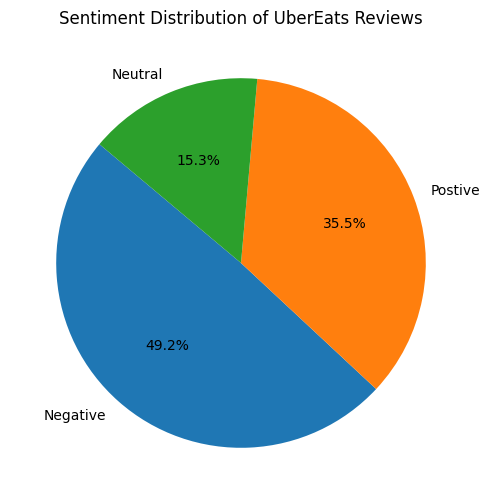

In [ ]:
import matplotlib.pyplot as plt

sentiment_counts = df_combined['sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution of UberEats Reviews')
plt.show()


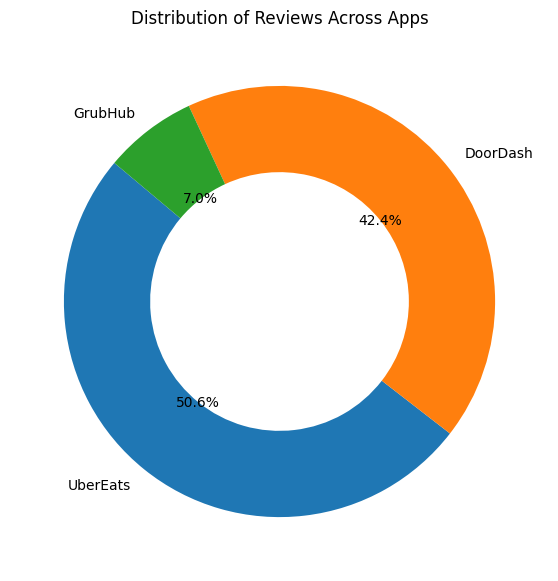

In [ ]:
import matplotlib.pyplot as plt

# STEP 1: Clean column names if needed
df_combined.columns = df_combined.columns.str.strip()

# STEP 2: Get the counts of each app_name
app_counts = df_combined['app_name'].value_counts()

# STEP 3: Create Pie Chart
plt.figure(figsize=(7,7))
plt.pie(
    app_counts,
    labels=app_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.4)  # For a nice donut look (optional)
)
plt.title('Distribution of Reviews Across Apps')
plt.show()


In [ ]:
# 1. Clean up app names and sentiments
df_combined['app_name'] = df_combined['app_name'].str.strip()
df_combined['sentiment'] = df_combined['sentiment'].str.strip().str.lower()

# 2. Check again
print("Unique app names:", df_combined['app_name'].unique())
print("Unique sentiments:", df_combined['sentiment'].unique())


Unique app names: ['UberEats' 'DoorDash' 'GrubHub']
Unique sentiments: ['neutral' 'negative' 'postive']


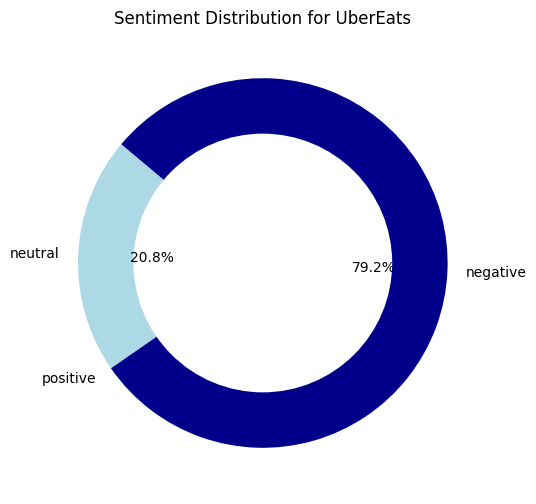

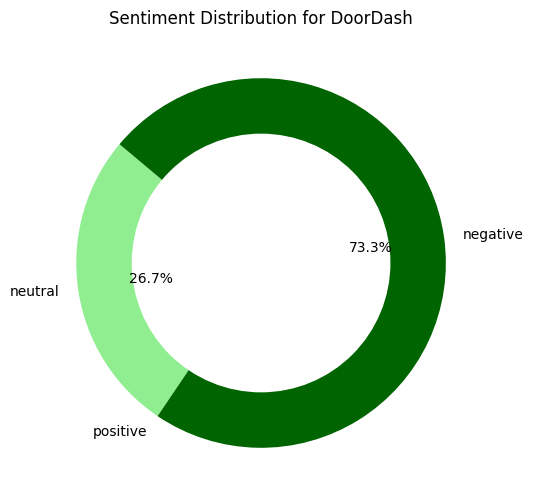

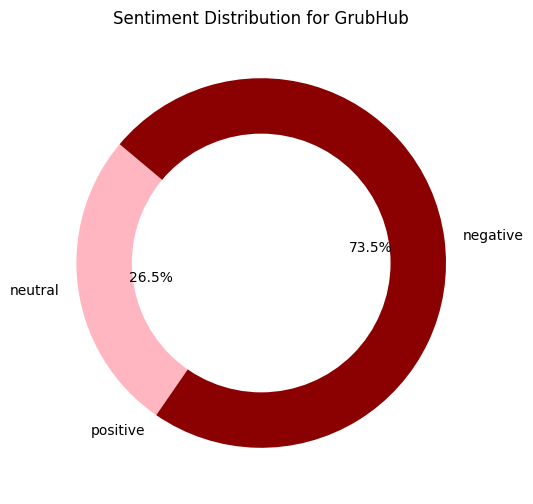

In [ ]:
import matplotlib.pyplot as plt

# Define app_colors again (no change needed)
app_colors = {
    'UberEats': {
        'neutral': '#ADD8E6',
        'positive': '#6495ED',
        'negative': '#00008B',
    },
    'DoorDash': {
        'neutral': '#90EE90',
        'positive': '#32CD32',
        'negative': '#006400',
    },
    'GrubHub': {
        'neutral': '#FFB6C1',
        'positive': '#FF6347',
        'negative': '#8B0000',
    }
}

# Define the plotting function
def plot_sentiment_pie(app_name):
    app_df = df_combined[df_combined['app_name'] == app_name]
    sentiment_counts = app_df['sentiment'].value_counts()
    sentiments = ['neutral', 'positive', 'negative']
    counts = [sentiment_counts.get(sentiment, 0) for sentiment in sentiments]

    if sum(counts) == 0:
        print(f"No data available for {app_name}, skipping...")
        return

    colors = [app_colors[app_name][sentiment] for sentiment in sentiments]

    plt.figure(figsize=(6,6))
    plt.pie(
        counts,
        labels=sentiments,
        colors=colors,
        autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
        startangle=140,
        wedgeprops=dict(width=0.4)
    )
    plt.title(f'Sentiment Distribution for {app_name}')

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.show()

# Plot for each app
for app in ['UberEats', 'DoorDash', 'GrubHub']:
    plot_sentiment_pie(app)


In [ ]:
# See UberEats sentiment counts
print(df_combined[df_combined['app_name'] == 'UberEats']['sentiment'].value_counts())


sentiment
negative    32011
postive     23754
neutral      8389
Name: count, dtype: int64


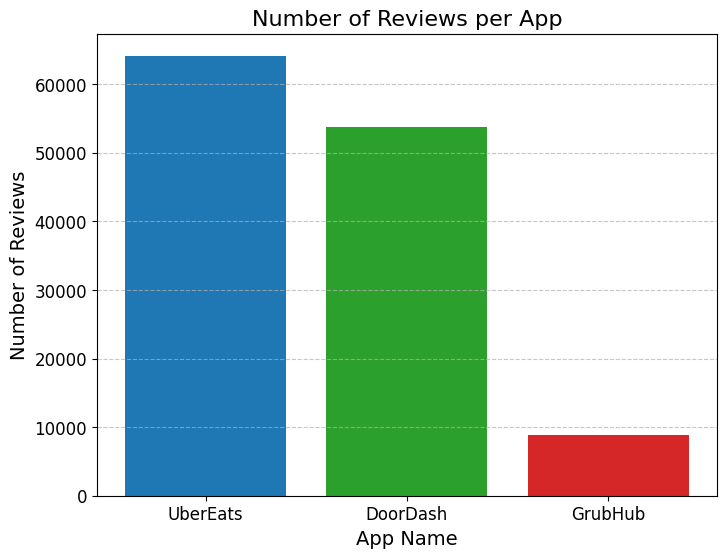

In [ ]:
import matplotlib.pyplot as plt

# STEP 1: Clean the data again (just to be safe)
df_combined['app_name'] = df_combined['app_name'].str.strip()
df_combined['sentiment'] = df_combined['sentiment'].str.strip().str.lower()

# STEP 2: Calculate the review counts for each app
app_review_counts = df_combined['app_name'].value_counts()

# STEP 3: Plot the bar chart
plt.figure(figsize=(8,6))
plt.bar(app_review_counts.index, app_review_counts.values, color=['#1f77b4', '#2ca02c', '#d62728'])
plt.title('Number of Reviews per App', fontsize=16)
plt.xlabel('App Name', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


sentiment
Negative    32011
Postive     23754
Neutral      8389
Name: count, dtype: int64
sentiment
Negative    25495
Postive     18968
Neutral      9264
Name: count, dtype: int64
sentiment
Negative    4799
Postive     2315
Neutral     1730
Name: count, dtype: int64
[[8389, 0, 32011], [9264, 0, 25495], [1730, 0, 4799]]


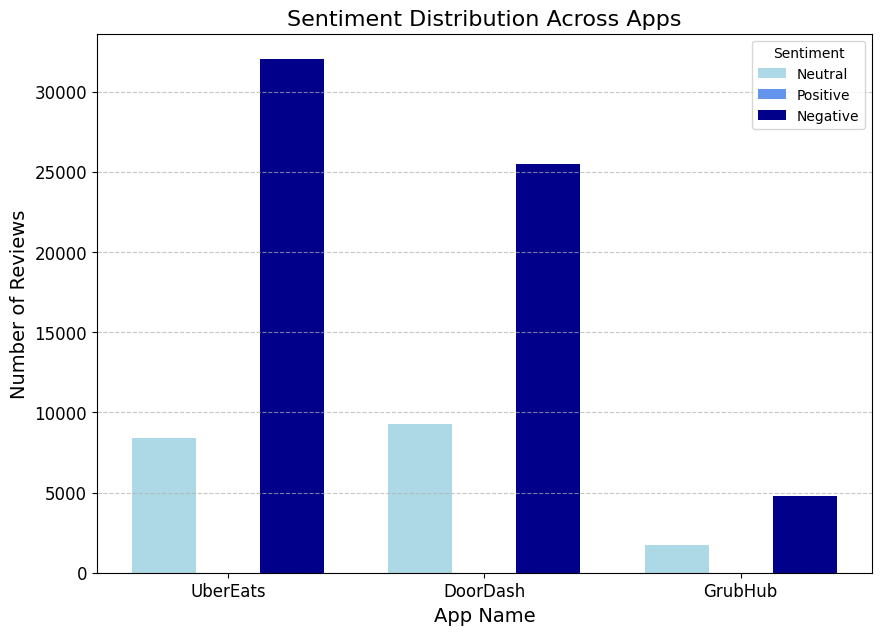

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# STEP 2: Calculate counts
sentiments = ['Neutral', 'Positive', 'Negative']
apps = ['UberEats', 'DoorDash', 'GrubHub']

# Create a matrix: rows = apps, columns = sentiments
count_matrix = []
for app in apps:
    app_counts = []
    app_df = df_combined[df_combined['app_name'] == app]
    sentiment_counts = app_df['sentiment'].value_counts()
    print(sentiment_counts)
    for sentiment in sentiments:
        app_counts.append(sentiment_counts.get(sentiment, 0))
    count_matrix.append(app_counts)
print(count_matrix)
count_matrix = np.array(count_matrix)  # shape = (3 apps, 3 sentiments)

# STEP 3: Plot
bar_width = 0.25
x = np.arange(len(apps))  # label locations

# Colors for sentiments
colors = ['#ADD8E6', '#6495ED', '#00008B']  # Light Blue, Medium Blue, Dark Blue

plt.figure(figsize=(10,7))

# Plot each sentiment
for i in range(len(sentiments)):
    plt.bar(x + i*bar_width, count_matrix[:, i], width=bar_width, label=sentiments[i].capitalize(), color=colors[i])

# X-ticks and labels
plt.xlabel('App Name', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.title('Sentiment Distribution Across Apps', fontsize=16)
plt.xticks(x + bar_width, apps, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
